In [1]:
"""demo: train a DND LSTM on a contextual choice task
"""
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from envs import ContextualChoice
from models import DNDLSTM as Agent
from models.utils import get_init_states, entropy
from models.DND import compute_similarities
from models import pick_action, get_reward, compute_returns, compute_a2c_loss
from sklearn.decomposition import PCA
from scipy.stats import sem

sns.set(style='white', context='talk', palette='colorblind')
seed_val = 0
torch.manual_seed(seed_val)
np.random.seed(seed_val)

In [2]:
# gen training set
trial_length = 10
t_noise_off = 5
obs_dim = 32
task = ContextualChoice(
    obs_dim=obs_dim, trial_length=trial_length,
    t_noise_off=t_noise_off
)

# num unique training examples in one epoch
M = 50
X, Y = task.sample(M)
n_trials = len(X)
print(f'X.size: {X.size()}, M x trial_length x x-dim')
print(f'Y.size: {Y.size()}, M x trial_length x y-dim')

X.size: torch.Size([100, 10, 64]), M x trial_length x x-dim
Y.size: torch.Size([100, 10, 1]), M x trial_length x y-dim


Text(-4.5, 0.5, 'x-dim: context | input')

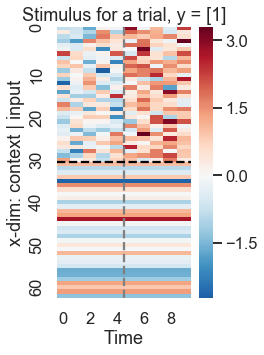

In [3]:
# show one trial
i = 0
input = X[i].numpy()
target = Y[i][0].numpy()
vmin = np.min(input)
vmax = np.max(input)

f, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.heatmap(
    input.T,
    vmin=vmin, vmax=vmax,
    cmap='RdBu_r', yticklabels=10, center=0,
    ax=ax
)
ax.axvline(t_noise_off, color='grey', linestyle='--')
ax.axhline(obs_dim, color='black', linestyle='--')
ax.set_title(f'Stimulus for a trial, y = {target}')
ax.set_xlabel('Time')
ax.set_ylabel('x-dim: context | input')

In [4]:
'''init the agent'''

# set params
dim_hidden = 32
dim_output = 2
dict_len = 100
learning_rate = 1e-3
n_epochs = 10
eta = 0

# init model and hidden state.
agent = Agent(task.x_dim, dim_hidden, dim_output, dict_len)
optimizer = torch.optim.Adam(agent.parameters(), lr=learning_rate)

In [5]:
'''train'''
log_return = np.zeros(n_epochs,)
log_ent = np.zeros(n_epochs,)
log_loss_value = np.zeros(n_epochs,)
log_loss_policy = np.zeros(n_epochs,)

log_Y = np.zeros((n_epochs, n_trials, trial_length))
log_Y_hat = np.zeros((n_epochs, n_trials, trial_length))
log_rgate = np.zeros((n_trials, trial_length, dim_hidden))

# loop over epoch
for i in range(n_epochs):
    time_start = time.time()
    # get data for this epoch
    X, Y = task.sample(M)
    # flush hippocampus
    agent.dnd.reset_memory()
    agent.turn_on_retrieval()

    # loop over the training set
    for m in range(n_trials):
        x_m, y_m = X[m], Y[m]
        # prealloc
        cumulative_reward = 0
        cumulative_entropy = 0
        probs, rewards, values = [], [], []
        h_t, c_t = get_init_states(dim_hidden)

        # loop over time, for one training example
        for t in range(trial_length):
            # only save memory at the last time point
            agent.turn_off_encoding()
            if t == trial_length-1 and m < M:
                agent.turn_on_encoding()
            # recurrent computation at time t
            outputs_ = agent(x_m[t].view(1, 1, -1), h_t, c_t)
            pi_a_t, v_t, h_t, c_t, cache_t = outputs_
            # action selection
            a_t, prob_a_t = pick_action(pi_a_t)
            # compute immediate reward
            r_t = get_reward(a_t, y_m[t])
            # compute response entropy
            cumulative_entropy += entropy(pi_a_t)
            # log
            probs.append(prob_a_t)
            rewards.append(r_t)
            values.append(v_t)
            # log
            cumulative_reward += r_t
            log_Y_hat[i, m, t] = a_t.item()
            [f_t, i_t, o_t, r_t, m_t] = cache_t
            log_rgate[m, t] = np.squeeze(r_t.data.numpy())

        returns = compute_returns(rewards)
        loss_policy, loss_value = compute_a2c_loss(probs, values, returns)
        loss = loss_policy + loss_value - eta * cumulative_entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # log
        log_Y[i] = np.squeeze(Y.numpy())
        log_ent[i] = cumulative_entropy / n_trials
        log_return[i] += cumulative_reward / n_trials
        log_loss_value[i] += loss_value.item() / n_trials
        log_loss_policy[i] += loss_policy.item() / n_trials

    # print out some stuff
    time_end = time.time()
    run_time = time_end - time_start
    print(
        'Epoch %3d | return = %.2f, ent = %.2f | loss: val = %.2f, pol = %.2f | time = %.2f' %
        (i, log_return[i], log_ent[i],
         log_loss_value[i], log_loss_policy[i], run_time)
    )

Epoch   0 | return = 6.55, ent = 0.07 | loss: val = 1.38, pol = -0.01 | time = 1.15
Epoch   1 | return = 7.94, ent = 0.04 | loss: val = 0.86, pol = -0.85 | time = 1.16
Epoch   2 | return = 7.82, ent = 0.04 | loss: val = 0.78, pol = -0.37 | time = 1.19
Epoch   3 | return = 7.76, ent = 0.03 | loss: val = 0.83, pol = -0.33 | time = 1.17
Epoch   4 | return = 7.69, ent = 0.02 | loss: val = 0.76, pol = -0.36 | time = 1.11
Epoch   5 | return = 8.35, ent = 0.02 | loss: val = 0.69, pol = -0.31 | time = 1.12
Epoch   6 | return = 8.13, ent = 0.01 | loss: val = 0.67, pol = -0.33 | time = 1.10
Epoch   7 | return = 8.14, ent = 0.02 | loss: val = 0.62, pol = -0.13 | time = 1.06
Epoch   8 | return = 8.12, ent = 0.01 | loss: val = 0.71, pol = -0.17 | time = 1.09
Epoch   9 | return = 8.19, ent = 0.02 | loss: val = 0.59, pol = -0.16 | time = 1.06


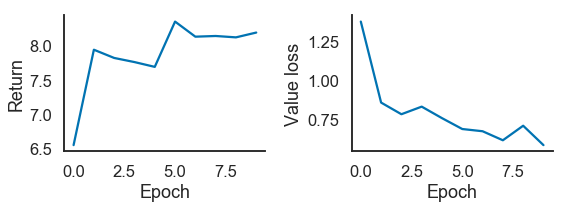

In [6]:
'''analysis'''
f, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(log_return)
axes[0].set_ylabel('Return')
axes[0].set_xlabel('Epoch')
axes[1].plot(log_loss_value)
axes[1].set_ylabel('Value loss')
axes[1].set_xlabel('Epoch')
sns.despine()
f.tight_layout()


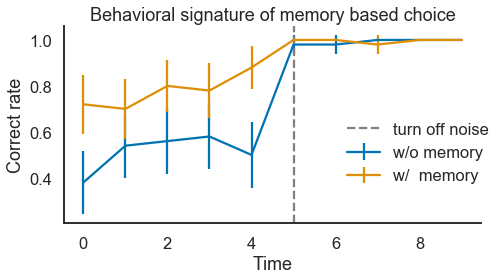

In [7]:
n_se = 2
# compute stat
corrects = log_Y_hat[-1] == log_Y[-1]
mu_mem0 = np.mean(corrects[:M], axis=0)
er_mem0 = sem(corrects[:M], axis=0) * n_se
mu_mem1 = np.mean(corrects[M:], axis=0)
er_mem1 = sem(corrects[M:], axis=0) * n_se

f, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(range(trial_length), y=mu_mem0, yerr=er_mem0, label='w/o memory')
ax.errorbar(range(trial_length), y=mu_mem1, yerr=er_mem1, label='w/  memory')
ax.axvline(t_noise_off, label='turn off noise', color='grey', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel('Correct rate')
ax.set_title('Behavioral signature of memory based choice')
f.legend(frameon=False, bbox_to_anchor=(1, .6))
sns.despine()
f.tight_layout()
# f.savefig('../figs/correct-rate.png', dpi=100, bbox_inches='tight')

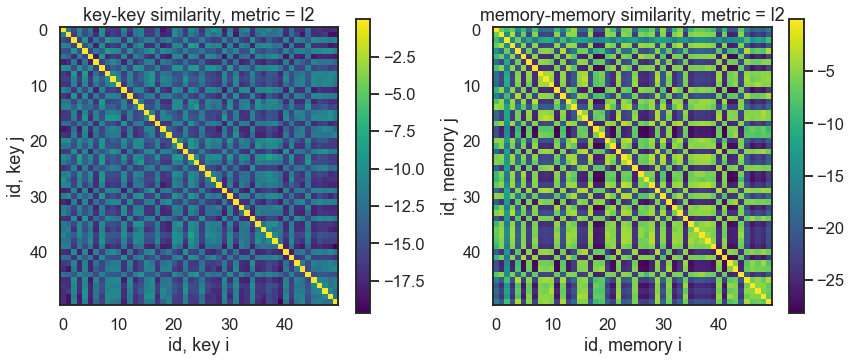

In [8]:
'''visualize keys and values'''
dmat_mm = np.zeros((len(agent.dnd.keys), len(agent.dnd.keys)))
dmat_kk = np.zeros((len(agent.dnd.keys), len(agent.dnd.keys)))

for i in range(len(agent.dnd.keys)):
    for j in range(len(agent.dnd.keys)):
        dmat_mm[i, j] = compute_similarities(
            agent.dnd.vals[i], [agent.dnd.vals[j]], agent.dnd.kernel
        ).item()
        dmat_kk[i, j] = compute_similarities(
            agent.dnd.keys[i], [agent.dnd.keys[j]], agent.dnd.kernel
        ).item()

# plot
dmats = [dmat_kk, dmat_mm]
labels = ['key', 'memory']

f, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, ax in enumerate(axes):
    im = ax.imshow(dmats[i], cmap='viridis')
    f.colorbar(im, ax=ax)
    ax.set_xlabel(f'id, {labels[i]} i')
    ax.set_ylabel(f'id, {labels[i]} j')
    ax.set_title(
        f'{labels[i]}-{labels[i]} similarity, metric = {agent.dnd.kernel}')
f.tight_layout()

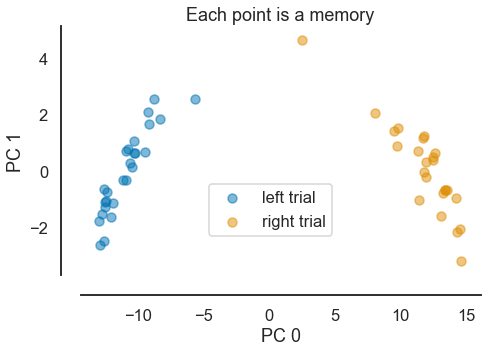

In [9]:
'''project memory content to low dim space'''

# organize the values to a numpy array, #memories x mem_dim
all_keys = np.vstack(
    [agent.dnd.keys[i].data.numpy() for i in range(len(agent.dnd.keys))])
all_vals = np.vstack(
    [agent.dnd.vals[i].data.numpy() for i in range(len(agent.dnd.vals))])
Y_phase2 = np.squeeze(Y[:M, 0].numpy())

# embed the memory to PC space
pca = PCA(n_components=10)
all_vals_pca = pca.fit_transform(all_vals)
# pick pcs
pc_x = 0
pc_y = 1

# plot
f, ax = plt.subplots(1, 1, figsize=(7, 5))
for y_val in np.unique(Y_phase2):
    y_mask = Y_phase2 == y_val
    ax.scatter(
        all_vals_pca[y_mask, pc_x],
        all_vals_pca[y_mask, pc_y],
        marker='o', alpha=.5,
    )
ax.set_title(f'Each point is a memory')
ax.set_xlabel(f'PC {pc_x}')
ax.set_ylabel(f'PC {pc_y}')
ax.legend(['left trial', 'right trial'], bbox_to_anchor=(.65, .4))
sns.despine(offset=20)
f.tight_layout()

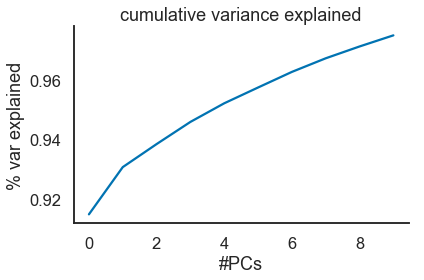

In [10]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_title('cumulative variance explained')
ax.set_xlabel('#PCs')
ax.set_ylabel('% var explained')
sns.despine()
f.tight_layout()

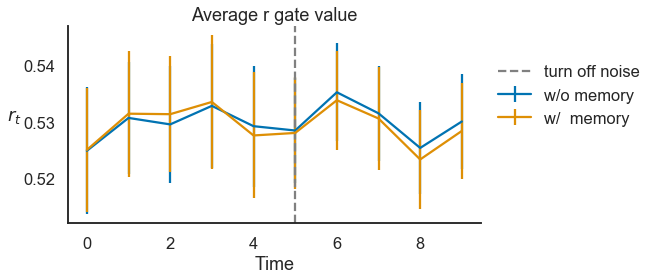

In [11]:
mean_rgate = np.mean(log_rgate, axis=-1)

n_se = 2
mu_mem0 = np.mean(mean_rgate[:M], axis=0)
er_mem0 = sem(mean_rgate[:M], axis=0) * n_se
mu_mem1 = np.mean(mean_rgate[M:], axis=0)
er_mem1 = sem(mean_rgate[M:], axis=0) * n_se

f, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.errorbar(range(trial_length), y=mu_mem0, yerr=er_mem0, label='w/o memory')
ax.errorbar(range(trial_length), y=mu_mem1, yerr=er_mem1, label='w/  memory')
ax.axvline(t_noise_off, label='turn off noise', color='grey', linestyle='--')
ax.set_xlabel('Time')
ax.set_ylabel(r'$r_t$'+'\t', rotation=0)
ax.set_title('Average r gate value')
f.legend(frameon=False, bbox_to_anchor=(1.3, .8))
sns.despine()
f.tight_layout()